# Local Rule Analysis

Local rules are equivalent to compute the conditional probabilities.

We aim on eco-friendly labels and categories.
The local rule "Label is Organic -> Beverage" means computing the probability of an object to be a beverage.

We then used those local rules to compare countries' behaviors regarding eco labels

In [1]:
import pandas as pd
import numpy as np
import scipy as scp
import scipy.stats
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from numpy.linalg import norm

import keras
from keras.layers import Input, Dense
from keras.models import Model
from keras import backend as K

import matplotlib.pyplot as plt

C:\Users\johan\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
DATAPATH='data/'

In [3]:
data = pd.read_csv(DATAPATH+'cleaned_unique_index.csv',low_memory=False)

In [4]:
data.set_index('code',inplace =True)

In [5]:
# data=data.sample(int(len(data) * .1))

In [6]:
data_labels=data.labels_en.dropna().str.split(',')
data_labels_exploded=data_labels.apply(pd.Series).unstack().dropna()

In [7]:
data_categories=data.categories_en.dropna().str.split(',')
data_categories_exploded=data_categories.apply(pd.Series).unstack().dropna()

In [8]:
data_categories_exploded.head()

   code         
0  0000000001281                               Pies
   0000000001885    Plant-based foods and beverages
   0000000005470    Plant-based foods and beverages
   0000000005661                            Seafood
   0000000020114                Dietary supplements
dtype: object

In [9]:
data_origins=data.origins.dropna().str.split(',')
data_origins_exploded=data_origins.apply(pd.Series).unstack().dropna()

In [10]:
data_origins_exploded=data_origins_exploded.map(lambda x: x.lstrip(' (').rstrip(' ).¨'))


## Translation of European countries

In [11]:
#origin translation
data_origins_exploded[data_origins_exploded=='Deutschland']='Germany'
data_origins_exploded[data_origins_exploded=='Allemagne']='Germany'
data_origins_exploded[data_origins_exploded=='Alemania']='Germany'


data_origins_exploded[data_origins_exploded=='Espagne']='Spain'
data_origins_exploded[data_origins_exploded=='Spanien']='Spain'
data_origins_exploded[data_origins_exploded=='España']='Spain'
data_origins_exploded[data_origins_exploded=='Espana']='Spain'
data_origins_exploded[data_origins_exploded=='Espanha']='Spain'
data_origins_exploded[data_origins_exploded=='Ispanija']='Spain'


data_origins_exploded[data_origins_exploded=='Hongrie']='Hungary'
data_origins_exploded[data_origins_exploded=='Ungarn']='Hungary'
data_origins_exploded[data_origins_exploded=='Ungaria']='Hungary'
data_origins_exploded[data_origins_exploded=='Ungheria']='Hungary'

data_origins_exploded[data_origins_exploded=='Autriche']='Austria'
data_origins_exploded[data_origins_exploded=='Österreich']='Austria'

data_origins_exploded[data_origins_exploded=='Frankreich']='France'
data_origins_exploded[data_origins_exploded=='Frankrijk']='France'
data_origins_exploded[data_origins_exploded=='Francia']='France'
data_origins_exploded[data_origins_exploded=='França']='France'

data_origins_exploded[data_origins_exploded=='Italia']='Italy'
data_origins_exploded[data_origins_exploded=='Italië']='Italy'
data_origins_exploded[data_origins_exploded=='Italie']='Italy'
data_origins_exploded[data_origins_exploded=='Italien']='Italy'
data_origins_exploded[data_origins_exploded=='Itália']='Italy'
data_origins_exploded[data_origins_exploded=='Itali']='Italy'


data_origins_exploded[data_origins_exploded=='Suiza']='Switzerland'
data_origins_exploded[data_origins_exploded=='Schweiz']='Switzerland'
data_origins_exploded[data_origins_exploded=='Suisse']='Switzerland'
data_origins_exploded[data_origins_exploded=='Switzerlandi']='Switzerland'
data_origins_exploded[data_origins_exploded=='Switzerlandi']='Switzerland'

data_origins_exploded[data_origins_exploded=='Belgique']='Belgium'
data_origins_exploded[data_origins_exploded=='Belgica']='Belgium'
data_origins_exploded[data_origins_exploded=='België']='Belgium'



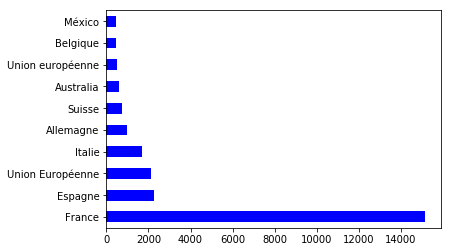

In [12]:
data_origins_exploded.value_counts().head(10).plot(kind='barh',color='b')

In [49]:
data_origins_exploded.to_frame()

0
   code                                                       
0  0000000274722                                        France
   0000000290616                                        Québec
   0000000394710                                        Québec
   0000001071894                                        France
   0000001938067                                        Québec
   0000004302544                                        Québec
   0000008237798                                        Québec
   0000008240095                                        Québec
   0000012167005                                        Québec
   0000020004552                                        France
   0000034152010                                        France
   00000758                                     United Kingdom
   00001373                                          Allemagne
   0000204286484                                     Allemagne
   0000204286644                                     Allemagne
   0000250632969                                     Allemagne
   00003100                                             France
   000039365                                                UE
   0000470322800                                     Allemagne
   0000501050603                                     Allemagne
   0000526938306                                     Allemagne
   0000790310044                                        Canada
   00011051096                                          France
   00015356                                    Grande Bretagne
   0002042861915                                     Allemagne
   000224                                               France
   00025751                                        Royaume-Uni
   00028202                                        Royaume-Uni
   0002983542515                                     Allemagne
   00033046                                     United Kingdom
...                                                        ...
18 3325710007338        Noix de Saint-Jacques (Chlamys nobilis
   8904063257581                                  Clove Powder
19 20681777                                          Indonésie
   20682095                                       Corée du Sud
   26048109                                         Iles Féroé
   3165440302507                                     Lettre (L
   3250390257127                                     Lettre (G
   3325710007338                                       Vietnam
   8904063257581                             Acidity Regulator
20 20681777                                          Thaïlande
   20682095                                             Russie
   26048109                                        Lettres (IF
   3165440302507  Noix de Saint-Jacques (Argopecten circularis
   3325710007338                                     Lettre (H
21 20681777                               Pacifique Nord-Ouest
   20682095                                            Vietnam
   26048109       Noix de Saint-Jacques (Argopecten circularis
   3165440302507                                           USA
   3325710007338   Noix de Saint-Jacques (Amusium pleuronectes
22 20681777                                             FAO 61
   26048109                                                USA
   3165440302507                                     Lettre (M
   3325710007338                                     Indonésie
23 26048109                                        Lettres (US
   3325710007338                                     Lettre (I
24 26048109                                            Mexique
   3325710007338   Noix de Saint-Jacques (Argopecten irradians
25 26048109                                          Lettre (M
   3325710007338                                           USA
26 3325710007338                                     Lettre (J

[53634 rows x 1 columns]

## Association rules learning

In [ ]:

data_origins_exploded.to_csv(DATAPATH+'quick_translate_origins.csv')


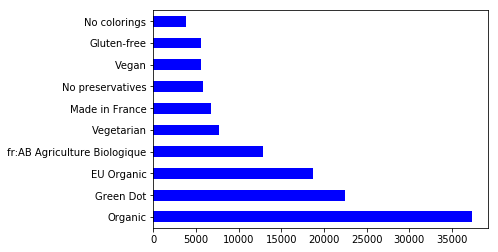

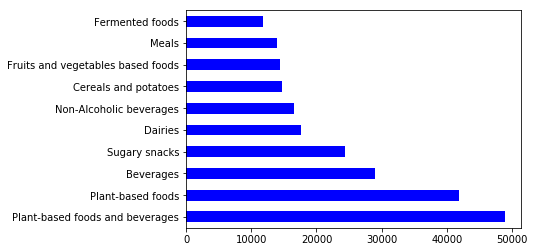

In [13]:
data_labels_exploded.value_counts().head(10).plot(kind='barh',color='b')
plt.show()
data_categories_exploded.value_counts().head(10).plot(kind='barh',color='b')
plt.show()

In [14]:
z=pd.DataFrame(data_labels_exploded).reset_index().set_index("code")[[0]]
z.columns=['label']
x=pd.DataFrame(data_categories_exploded).reset_index().set_index('code')[[0]]
x.columns=['category']

In [15]:
#to be removedin case f problem

organic=z[z['label'] == 'Organic']
green_dot=z[z['label'] == 'Green Dot']
eu_organ=z[z['label'] == 'EU Organic']
z=pd.concat([organic,green_dot,eu_organ])

In [16]:
z=pd.DataFrame(data_labels_exploded).reset_index().set_index("code")[[0]]
z.columns=['label']
x=pd.DataFrame(data_categories_exploded).reset_index().set_index('code')[[0]]
x.columns=['category']
origins_=pd.DataFrame(data_origins_exploded).reset_index().set_index("code")[[0]]
origins_.columns=['origin']

f=x.join(z).dropna()
f['joined']=f['category']+','+f['label']




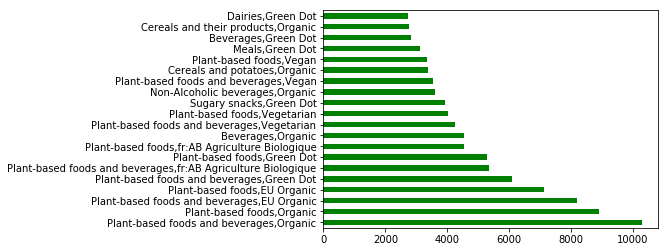

In [17]:
f['joined'].value_counts().head(20).plot(kind='barh',color='g')

plt.show()

In [18]:
highest_support=pd.Series(f['joined'].value_counts().head(20).index.values)

grouped_=list(zip(*(highest_support.str.split(',').values)))
highest_categories=np.unique(list(grouped_[0]))
highest_labels=np.unique(list(grouped_[1]))
highest_categories=highest_categories.tolist()
highest_labels=highest_labels.tolist()


In [19]:
def cosine_similarity(array1,array2):
    return np.divide(np.dot(array1,array2),norm(array1)*norm(array2))


In [20]:
def pearson_similarity(array1,array2):
    array1_=np.subtract(array1,np.mean(array1))
    array2_=np.subtract(array2,np.mean(array2))
    return np.divide(np.dot(array1_,array2_),norm(array1_)*norm(array2_))

In [21]:
def tanimoto_similarity(array1,array2):
    dividende=np.dot(array1,array2)
    divisor=np.dot(array1,array1)+np.dot(array2,array2)-dividende
    return dividende/divisor

In [22]:
cosine_similarity(np.array([1,0,3]),np.array([1,2,3]))

0.8451542547285166

In [23]:
pearson_similarity(np.array([1,0,3]),np.array([1,2,3]))

0.654653670707977

In [24]:
def define_local_rules(origin=None):
    local_rules={}
    origins_=pd.DataFrame(data_origins_exploded).reset_index().set_index("code")[[0]]
    origins_.columns=['origin']
    x_=x.copy()
    z_=z.copy()
    if origin:

        origins_=origins_[origins_['origin']==origin]
        z_=z.join(origins_).dropna().drop(columns=['origin'])
        x_=x.join(origins_).dropna().drop(columns=['origin'])



    f=x_.join(z_).dropna()
    f['joined']=f['category']+','+f['label']
    support=f['joined'].value_counts()
    label_counts=f['label'].value_counts()
    category_counts=f['category'].value_counts()

    for label in highest_labels:

        for category in highest_categories:


            string_=category+','+label
            if string_ in support.index:
                local_rules[label+' -> '+category]=support.loc[category+','+label]/label_counts.loc[label]
                local_rules[category+' -> '+label]=support.loc[category+','+label]/category_counts.loc[category]
            else:
                local_rules[label+' -> '+category]=0.
                local_rules[category+' -> '+label]=0.
    return local_rules.copy()


In [25]:
general_local_rules=define_local_rules()
germany_local_rules=define_local_rules('Allemagne')
france_local_rules=define_local_rules('France')
belgium_local_rules=define_local_rules('Belgique')
spain_local_rules=define_local_rules('Espagne')
italy_local_rules=define_local_rules('Italie')
switzerland_local_rules=define_local_rules('Suisse')

# First Glance at local Rules

We excpect a lot of 0.0 in our dictionnaries, especially in the country-based one, because the support reference was made on the whole data set. Let's have a look of some entries.

In [26]:
print(general_local_rules['Organic -> Beverages'])
print(general_local_rules['Beverages -> EU Organic'])
print(general_local_rules['EU Organic -> Beverages'])
print(general_local_rules['Beverages -> Organic'])

0.03288202565480773
0.0649865891819401
0.02190104044065722
0.1264807778274475


There is something surprising: a quarter of beverages are EU organic, and almost half of the beverages are Organic.

How is it represented in France, and other european countries
    

In [27]:
print('organic beverage in france')
print(france_local_rules['Organic -> Beverages'])
print(france_local_rules['Beverages -> EU Organic'])
print(france_local_rules['EU Organic -> Beverages'])
print(france_local_rules['Beverages -> Organic'])

organic beverage in france
0.01920955285871893
0.059189313680331646
0.019530359449806217
0.06817134960847536


In [28]:
print('organic beverage in spain')
print(spain_local_rules['Organic -> Beverages'])
print(spain_local_rules['Beverages -> EU Organic'])
print(spain_local_rules['EU Organic -> Beverages'])
print(spain_local_rules['Beverages -> Organic'])

organic beverage in spain
0.009898107714701601
0.06766917293233082
0.008835078534031414
0.08521303258145363


# Comparison at large scale

Because it can be tedious to compare each rule one after one other, considering local rules values as vectors can allow to compare them in a faster way. 

There are several ways to compute vector similiraty, here we use three of them:
 * linear correlation
 $$\frac{Cov(x,y)}{\sqrt{ Var(x)Var(y)}}$$
 * cosine similarity
 $$\frac{\sum x_i y_i}{\sqrt{ \sum{x_i^2} \sum{y_i^2}}}$$
 * Tanimoto distance
 $$\frac{\sum x_i y_i}{\sum{x_i^2} + \sum{y_i^2} -\sum x_i y_i}$$
 
 As there is no theoretical reason to prefer one of them, they are all computed and compared.
 It turns out that they are equivalent **in the selected countries**:  sim1(country A, country B) < sim1(countryC, countryD) iff sim2(country A, country B) < sim2(countryC, countryD)


In [29]:
values=np.zeros((7,len(general_local_rules)))
values[0]=list(general_local_rules.values())
values[1]=list(germany_local_rules.values())
values[2]=list(france_local_rules.values())
values[3]=list(belgium_local_rules.values())
values[4]=list(spain_local_rules.values())
values[5]=list(italy_local_rules.values())
values[6]=list(switzerland_local_rules.values())

In [30]:
cosine_similarities = np.zeros((7,7))
for i in range(7):
    for j in range(7):
        cosine_similarities[i,j]=cosine_similarity(values[i],values[j])

In [31]:
cosine_similarity_frame=pd.DataFrame(cosine_similarities)
cosine_similarity_frame.columns=['World','Germany','France','Belgium','Spain','Italy','Switzerland']
cosine_similarity_frame.index=['World','Germany','France','Belgium','Spain','Italy','Switzerland']


In [32]:
pearson_similarities = np.zeros((7,7))
for i in range(7):
    for j in range(7):
        pearson_similarities[i,j]=pearson_similarity(values[i],values[j])

In [33]:
pearson_similarity_frame=pd.DataFrame(pearson_similarities)
pearson_similarity_frame.columns=['World','Germany','France','Belgium','Spain','Italy','Switzerland']
pearson_similarity_frame.index=['World','Germany','France','Belgium','Spain','Italy','Switzerland']

In [34]:
tanimoto_similarities = np.zeros((7,7))
for i in range(7):
    for j in range(7):
        tanimoto_similarities[i,j]=tanimoto_similarity(values[i],values[j])

In [35]:
tanimoto_similarity_frame=pd.DataFrame(tanimoto_similarities)
tanimoto_similarity_frame.columns=['World','Germany','France','Belgium','Spain','Italy','Switzerland']
tanimoto_similarity_frame.index=['World','Germany','France','Belgium','Spain','Italy','Switzerland']

In [36]:
print('Cosine similarities')
cosine_similarity_frame

Cosine similarities


,World,Germany,France,Belgium,Spain,Italy,Switzerland
World,1.000000,0.880475,0.953258,0.811140,0.817744,0.947444,0.843709
Germany,0.880475,1.000000,0.809927,0.685146,0.763366,0.912983,0.872729
France,0.953258,0.809927,1.000000,0.847881,0.697466,0.919281,0.794869
Belgium,0.811140,0.685146,0.847881,1.000000,0.597243,0.756683,0.610838
Spain,0.817744,0.763366,0.697466,0.597243,1.000000,0.739327,0.682886
Italy,0.947444,0.912983,0.919281,0.756683,0.739327,1.000000,0.858608
Switzerland,0.843709,0.872729,0.794869,0.610838,0.682886,0.858608,1.000000


In [37]:
print('Linear correlation similarities')
pearson_similarity_frame

Linear correlation similarities


,World,Germany,France,Belgium,Spain,Italy,Switzerland
World,1.000000,0.741009,0.895986,0.651448,0.588606,0.888902,0.675517
Germany,0.741009,1.000000,0.603827,0.429347,0.517755,0.822154,0.752219
France,0.895986,0.603827,1.000000,0.726409,0.359716,0.828740,0.588059
Belgium,0.651448,0.429347,0.726409,1.000000,0.260623,0.556835,0.308796
Spain,0.588606,0.517755,0.359716,0.260623,1.000000,0.459615,0.374271
Italy,0.888902,0.822154,0.828740,0.556835,0.459615,1.000000,0.721226
Switzerland,0.675517,0.752219,0.588059,0.308796,0.374271,0.721226,1.000000


In [38]:
print('Tanimoto distance similarities')
tanimoto_similarity_frame

Tanimoto distance similarities


,World,Germany,France,Belgium,Spain,Italy,Switzerland
World,1.000000,0.786461,0.892397,0.680693,0.666601,0.874457,0.720660
Germany,0.786461,1.000000,0.669163,0.520145,0.595055,0.815620,0.763732
France,0.892397,0.669163,1.000000,0.730370,0.487313,0.775593,0.622655
Belgium,0.680693,0.520145,0.730370,1.000000,0.405612,0.584012,0.430435
Spain,0.666601,0.595055,0.487313,0.405612,1.000000,0.585888,0.515274
Italy,0.874457,0.815620,0.775593,0.584012,0.585888,1.000000,0.750227
Switzerland,0.720660,0.763732,0.622655,0.430435,0.515274,0.750227,1.000000


# Data Viz

Previous method suggest different shades of similarities: e.g Switzerland and Belgium are less similar than France and Italy.

To represent those similarities in a more direct way via data visualization. An immediate drawback of that approach is that we need to project the local rule values onto a 2D space for representation sake. This dimensionality reduction is surely to high.

We used three method
 * PCA: this method directly project the data onto a space were the new features are uncorrelated. PCA is often used to reduce dimensionality by taking the principal components with highest variances. However, it only takes in account linear correlation and not depances in general.
 * ICA: coming from signal source demixing problem, ICA tries to retrieve the weights of the different sources, under the assumption that the pure sources are non gaussian.
 * Autoencoder: a techniques based on neural network. the NN is  has different hidden layers, including the coder which has usually a low number of neurons. The NN is trained to reproduced the same data from input to output. Once trained, values at the coder layer represent a non-linear projection of data onto a lower dimensional space.

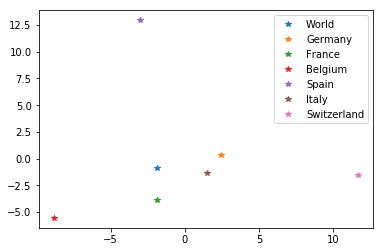

In [39]:
std_values=np.subtract(values,values.mean(axis=0))
std_values=np.divide(std_values,std_values.std(axis=0)+1e-14)
pca=PCA(n_components=2)
pca_results=pca.fit_transform(std_values)
for i in range(7):
    plt.plot(pca_results[i,0],pca_results[i,1],'*')
plt.legend(['World','Germany','France','Belgium','Spain','Italy','Switzerland'])
plt.xlabel('Principal componant 1')
plt.ylabel('Principal componant 2')
plt.show()

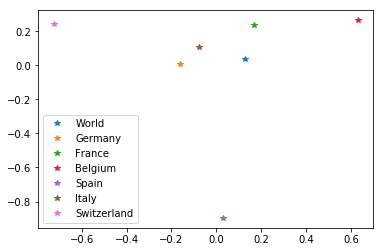

In [40]:
fast_ica=FastICA(n_components=2)
fast_ica_results=fast_ica.fit_transform(std_values)
for i in range(7):
    plt.plot(fast_ica_results[i,0],fast_ica_results[i,1],'*')
plt.legend(['World','Germany','France','Belgium','Spain','Italy','Switzerland'])
plt.xlabel('Independant componant 1')
plt.ylabel('Independant componant 2')
plt.show()

In [41]:
input_=Input(shape=(values.shape[1],))
first_layer=Dense(128,activation='selu')(input_)
second_layer=Dense(64,activation='selu')(first_layer)
coder=Dense(2,activation='linear')(second_layer)
decode_second_layer=Dense(64,activation='selu')(coder)
decode_first_layer=Dense(128,activation='selu')(decode_second_layer)
output=Dense(values.shape[1],activation='linear')(decode_first_layer)

autencoder=Model(input_,output)
encoded=Model(input_,coder)
autencoder.compile(optimizer='adam',loss='mean_squared_error')


In [42]:
history=autencoder.fit(std_values,std_values,epochs=300,verbose=0)

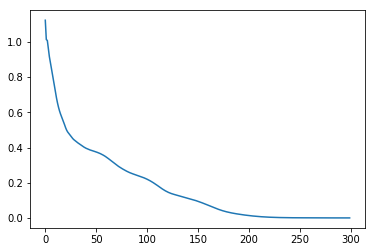

In [43]:
plt.plot(history.history['loss'])

In [44]:
encoded_values=encoded.predict(std_values)

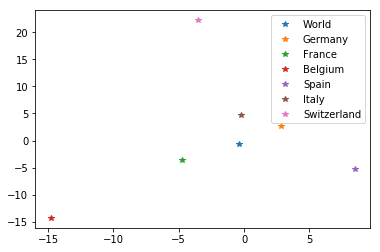

In [45]:
for i in range(7):
    plt.plot(encoded_values[i,0],encoded_values[i,1],'*')
plt.legend(['World','Germany','France','Belgium','Spain','Italy','Switzerland'])
plt.xlabel('Latent feature 1')
plt.ylabel('Latent feature 2')
plt.savefig('autoencoder.png',bbox='tight')
plt.show()